# Sarcasm Detection
 **Acknowledgement**

Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

## Install `Tensorflow2.0` 

In [1]:
!!pip uninstall tensorflow
!pip install tensorflow==2.0.0

  Using cached https://files.pythonhosted.org/packages/46/0f/7bd55361168bb32796b360ad15a25de6966c9c1beb58a8e30c01c8279862/tensorflow-2.0.0-cp36-cp36m-manylinux2010_x86_64.whl


## Get Required Files from Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#Set your project path 
project_path =  '/content/drive/My Drive/'

#**## Reading and Exploring Data**

## Read Data "Sarcasm_Headlines_Dataset.json". Explore the data and get  some insights about the data. ( 4 marks)
Hint - As its in json format you need to use pandas.read_json function. Give paraemeter lines = True.

In [4]:
import os

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df=pd.read_json(os.path.join(project_path,'Sarcasm_Headlines_Dataset.json'),lines=True)
df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [6]:
print(df.shape)
df.describe()

(26709, 3)


,is_sarcastic
count,26709.000000
mean,0.438953
std,0.496269
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
df['is_sarcastic'].value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

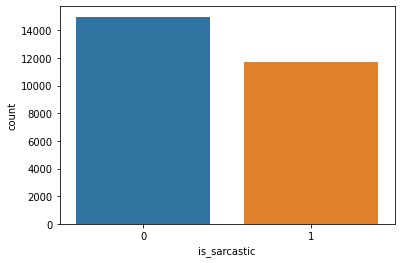

In [8]:
sns.countplot(df['is_sarcastic'])

### Observations:

1)The dataset has 26709 enteries each associated with 3 features: article_link, headline and is_sarcastic
2)The number of headlines that are 'not sarcastic (0)' outnumber the ones that are categorised as 'sarcastic (1)'

In [9]:
# Text preprocessing: Remove punctuations and stopwords from 'headline'

import nltk
import re
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words=set(stopwords.words('english'))
from nltk.tokenize import word_tokenize

def data_preprocess(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = word_tokenize(text)
    text = [w for w in text if not w in stop_words]   
    text = " ".join(text)
    return text

df['headline']=df['headline'].apply(data_preprocess)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues secret black c...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,roseanne revival catches thorny political mood...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting fear sons web series closest thin...,1
3,https://politics.theonion.com/boehner-just-wan...,boehner wants wife listen come alternative deb...,1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,jk rowling wishes snape happy birthday magical...,0


## Drop `article_link` from dataset. ( 2 marks)
As we only need headline text data and is_sarcastic column for this project. We can drop artical link column here.

In [10]:
df=df.drop(['article_link'], axis=1)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues secret black c...,0
1,roseanne revival catches thorny political mood...,0
2,mom starting fear sons web series closest thin...,1
3,boehner wants wife listen come alternative deb...,1
4,jk rowling wishes snape happy birthday magical...,0


## Get the Length of each line and find the maximum length. ( 4 marks)
As different lines are of different length. We need to pad the our sequences using the max length.

In [11]:
df['headline_length']=df.apply(lambda x: len(x['headline'].split()), axis=1)
df.head()

,headline,is_sarcastic,headline_length
0,former versace store clerk sues secret black c...,0,10
1,roseanne revival catches thorny political mood...,0,8
2,mom starting fear sons web series closest thin...,1,9
3,boehner wants wife listen come alternative deb...,1,8
4,jk rowling wishes snape happy birthday magical...,0,8


In [12]:
df['headline_length'].max()

27

### Observation:

The maximum length or the maximum number of words is 27. 

In [13]:
df.drop(['headline_length'], axis=1, inplace=True)
df.head(2)

,headline,is_sarcastic
0,former versace store clerk sues secret black c...,0
1,roseanne revival catches thorny political mood...,0


#**## Modelling**

## Import required modules required for modelling.

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

# Set Different Parameters for the model. ( 2 marks)

In [0]:
max_features = 10000
maxlen = 27
embedding_size = 200

## Apply Keras Tokenizer of headline column of your data.  ( 4 marks)
Hint - First create a tokenizer instance using Tokenizer(num_words=max_features) 
And then fit this tokenizer instance on your data column df['headline'] using .fit_on_texts()

In [0]:
tokenizer=Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['headline'])


# Define X and y for your model.

In [17]:
X = tokenizer.texts_to_sequences(df['headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(df['is_sarcastic'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 26709
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  204  692 3437 2129  267   33 2026 2397 8167]
Number of Labels:  26709
0


## Get the Vocabulary size ( 2 marks)
Hint : You can use tokenizer.word_index.

In [18]:
word_index=tokenizer.word_index
num_words = len(word_index)+1
print(num_words)


28276


#**## Word Embedding**

## Get Glove Word Embeddings

In [0]:
glove_file = project_path +"glove.6B.zip"

In [0]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

# Get the Word Embeddings using Embedding file as given below.

In [0]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE, encoding='utf8'):
    word = o.split(" ")[0]
    #print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    #print(embd)
    embeddings[word] = embd



# Create a weight matrix for words in training docs

In [22]:
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())
print(embedding_matrix.shape)

(28276, 200)


## Create and Compile your Model  ( 7 marks)
Hint - Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.


In [23]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import LSTM, Bidirectional, Dropout, Dense

model = Sequential()
model.add(Embedding(num_words, output_dim=embedding_size, weights=[embedding_matrix], input_length=maxlen))
model.add(Bidirectional(LSTM(units=128)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 27, 200)           5655200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 5,992,353
Trainable params: 5,992,353
Non-trainable params: 0
_________________________________________________________________


# Fit your model with a batch size of 100 and validation_split = 0.2. and state the validation accuracy ( 5 marks)


In [24]:
batch_size = 100
epochs = 5

## Add your code here ##
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/5
21367/21367 [==============================] - 71s 3ms/step - loss: 0.5057 - accuracy: 0.7467
Epoch 2/5
21367/21367 [==============================] - 70s 3ms/step - loss: 0.3389 - accuracy: 0.8526
Epoch 3/5
21367/21367 [==============================] - 70s 3ms/step - loss: 0.2468 - accuracy: 0.8962
Epoch 4/5
21367/21367 [==============================] - 69s 3ms/step - loss: 0.1763 - accuracy: 0.9301
Epoch 5/5
21367/21367 [==============================] - 69s 3ms/step - loss: 0.1234 - accuracy: 0.9535


In [25]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f%%' %(accuracy*100))
print('Test Loss: %.4f' % (loss))

5342/5342 [==============================] - 6s 1ms/step
Accuracy: 82.07%
Test Loss: 0.5552


### Conclusions:
The dataset was fit using pretrained Glove Embedding with 200 faetures and LSTM architecture. The model gave an accuracy of 82%.